In [105]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
%autoreload 2

# Import of files with Code necessary for evalution of data

In [107]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
from collections import Counter
import pandas as pd
import numpy as np

'''Classes for Reading in the Data and applying DS Inversion and Interference corr'''
from nu_data_reduction import NU_data_read, normalisation, evaluation
from parameter import Sn_meas_obj, spike_obj
from dspike_formulas import *

import pylab as plt

# Input path to raw files and type of corrections

In [223]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2018-01-10/raw files/"
#path = "/Users/marf/Desktop/PhD Temp/2018-01-10/"
files_start = 9073#8922
files_end = 9248#8970

files_1 = range(files_start, files_end, 1)
#files_1 = range(8808,8915,1) + range(8922,9061, 1)

In [224]:
# Isotopes used for Spike Inversion [[denominator isotope], nominator isotopes, .. ]
spikeSn_ls = [["117"],["118", "122", "124"]]

### spike and standard composition already defined in parameter.py ###

# Dictionary with pure DS composition
#spike_dict_117_122_meas = {"118": 0.0102951622334242, "119": 0.0090731830784630, "120" : 0.0338645175569080, "122" : 0.8068023572167630, "124" : 0.0114846216495240} # DS compositon 1ppm - 15.09.17

# Dictionary with Standard composition
#meas_dict = { "118" : 3.15777585757689, "119" : 1.11972979701600, "120" : 4.25050484928267, "122" : 0.60392336483548, "124" : 0.754692491283485} # mean of 1ppm NIST Std used for calib-15.09.17
# Denominator isotope in ratios for DS & Std composition
#meas_denom_117 = "117"

# Load compositions in for DS inversion
#Sn_meas_obj = load_ratio_dict(meas_dict, meas_denom_117)
#spike_obj = load_ratio_dict(spike_dict_117_122_meas, meas_denom_117)


In [225]:
# cup configuration
Sn_isotopes = ["117", "118", "119", "120", "122", "124"]
cup_config = cycles_spike

# Mass Range of cup configuration
mass_range = cycle_Sn_spike_mass_range

# Isotopes used for Interference correction
corr_isotopes_2 = {"Te" : "126", "Xe" : "129"}
#corr_isotopes_2 = {}
#corr_isotopes_Sb = {"Te": "125"}

denom_isotope = "117"
Sn_monitor = ["126"]
  
isotopes = [["118", "119", "120", "122", "124"]]
data_sample_column = [(i + "/" + denom_isotope) for i in isotopes[0]]  

# Amount of interations for estimation of instrumental and natural fractionation
loop_nat = 3
loop_ins = 6

# assumended instrumental and natural fractionation
start_nat = -0.1 #start_nat = -0.1; start_nat = 1000
start_ins = 2 #start_ins = 2; start_ins = 0.001
# isotope ratio used for calculation of instrumental and natural fractionation [denominator[x, y, z]] e.g. [117,[118, 122, 124]] x = 118/117
inv_iso_ratio = 'x'

# Mass fractionation law ("exp" or "GPL")
law = "exp"

# n for GPL
n_GPL_ins = 0.3
n_GPL_nat = 0.001

# background correction
blk_corr = True

In [226]:
mass_range.get_graph_of_corr(corr_isotopes_2)

{'117': set(),
 '118': set(),
 '119': set(),
 '120': {'126'},
 '121': set(),
 '122': {'126'},
 '123': {'126'},
 '124': {'126', '129'},
 '125': set(),
 '126': {'129'},
 '127': set(),
 '129': set(),
 '131': set()}

In [227]:
# show graph of correction used for interference correction
mass_range.get_order_of_corr(corr_isotopes_2)

[{'117', '118', '119', '121', '125', '127', '129', '131'},
 {'126'},
 {'120', '122', '123', '124'}]

# Extract Signals & List with samples and blanks

In [228]:
# creates a dataframe with all zero corrected signals on the cups
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []

for sample in files_1:
    
    # read data from csv file
    df = NU_data_read(path, sample, cup_config)
    # determine number of cycles of file
    cycles = range(1, len(df.data_read(sample).index)+1)
    # perform baseline correction
    df_zero = df.data_zero_corr(sample)
    # create dataframe with baseline corrected data
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    # extract sample name from csv
    sample_name = df.extract_metadata(sample, "Sample Name")
    # extract date from csv
    date = df.extract_metadata(sample, "Date")
    # extract time from csv
    starttime = df.extract_metadata(sample, "Start Time")
    
    # add columns for date, sample, cycles to dataframe
    # combine date and starttime
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    # use datetime as dataframe index
    df_zero_1.index = df_zero_1["date"]
    # sort dataframe by columns_1
    df_zero_1 = df_zero_1[columns_1]
    # copy data of each sample behind each other in new dataframe
    df_all = df_all.append(df_zero_1, ignore_index = True)
    
    # create list with sample file numbers of sample measurements and blank measurements
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)
# use datetime as dataframe index
df_all.set_index("date", inplace = True)

#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(5234)

In [229]:
### shows baseline corrected signals
df_all[df_all["sample"] == "blank sol"].groupby(df_all[df_all["sample"] == "blank sol"].index).agg(np.mean)

,cycle,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),Ax (1),L1 (1),L2 (1),L3 (1),L4 (1)
date,,,,,,,,,,,,,,
2018-01-11 11:21:00,10.5,0.011462,0.013938,0.008833,0.000240,0.000066,0.000238,-2.467586e-03,0.000603,0.000464,0.002351,0.000207,0.000601,0.000756
2018-01-11 11:38:00,10.5,0.011457,0.013933,0.008797,0.000244,0.000060,0.000267,5.256499e-03,0.000630,0.000464,0.002411,0.000233,0.000643,0.000824
2018-01-11 11:55:00,10.5,0.011454,0.013921,0.008767,0.000241,0.000073,0.000280,4.077936e-02,0.000643,0.000449,0.002365,0.000240,0.000604,0.000820
2018-01-11 12:11:00,10.5,0.011468,0.013933,0.008698,0.000234,0.000069,0.000228,-2.075904e-02,0.000673,0.000431,0.002424,0.000234,0.000639,0.000900
2018-01-11 12:28:00,10.5,0.011441,0.013887,0.008686,0.000236,0.000061,0.000266,3.409379e-04,0.000724,0.000452,0.002477,0.000255,0.000698,0.000949
2018-01-11 12:45:00,10.5,0.011417,0.013884,0.008652,0.000237,0.000068,0.000275,1.665471e-02,0.000734,0.000455,0.002408,0.000238,0.000651,0.000942
2018-01-11 13:02:00,10.5,0.011439,0.013894,0.008641,0.000224,0.000072,0.000262,3.438704e-04,0.000797,0.000468,0.002487,0.000245,0.000704,0.001013
2018-01-11 13:19:00,10.5,0.011488,0.013951,0.008612,0.000234,0.000060,0.000253,3.409893e-04,0.000843,0.000448,0.002457,0.000243,0.000682,0.001095
2018-01-11 13:35:00,10.5,0.011451,0.013919,0.008602,0.000237,0.000074,0.000277,3.498972e-04,0.000834,0.000434,0.002454,0.000254,0.000699,0.001095


# DS-inversion for all samples in sample list

In [263]:
### performs dataevaluation for all sample data ###

files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_DS_inv= pd.DataFrame()
df_int_corr_all = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        # Reads signals of Blank measurements
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
        # Outlier correction on signals of blank measurements
        df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        # Background substraction of blank signals
        new_corr.data_bgd_corr_2(df_bgd_1, df_bgd_2)
    
    # No background correction
    else:
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
    
    # Gives zero_corrected Signals back & writes it in a dataframe
    data_sample_raw = new_corr.raw_signals_all()
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    #Get raw ratios
    data_sample = new_corr.raw_ratios(denom_isotope)
    # raw ratios from dataframe in dictionary for data handling
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    # First DS-inversion without interference correction
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_masses, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    # Beta for interference correction
    beta = data_spike_calc["frac_ins_x2.5"]
    # Interference correction
    spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    # interference corrected raw ratios
    data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')
    # Second DS-inversion
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_masses, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc_2 = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    #Calculation of eSn
    data_spike_calc_2["Filenumber"] = sample
    data_spike_calc_2["eSn_118_117"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
    data_spike_calc_2["eSn_122_117"] = ((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["n0:y"])-1)*10000
    data_spike_calc_2["eSn_124_117"] = ((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["n0:z"])-1)*10000
    data_spike_calc_2["eSn_122_118"] = (((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:y"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["eSn_124_118"] = (((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:z"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["fsam"] = 1/((data_spike_calc_2["Mr2.5:x"]*0.07669971 - 0.24220048)/(0.00525699 - data_spike_calc_2["Mr2.5:x"]*0.51062751)+1)
    data_spike_calc_2["fspike"] = 1-data_spike_calc_2["fsam"]
    data_spike_calc_2["Q"] = data_spike_calc_2["fsam"]/data_spike_calc_2["fspike"]
    #Outlier rejection
    data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)
    
    # Extraction of Sample Name, Date, Measurement time and add it to Dataframe
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_spike_calc_2["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_spike_calc_2["sample"] = sample_name
    data_spike_calc_2["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_spike_calc_2 = data_spike_calc_2.merge(data_sample_raw)
    
    # Add each sample in for loop to a dataframe
    df_DS_inv = df_DS_inv.append(data_spike_calc_2)
    
    # Dataframe with amount of Interference corr - raw ratios before corr - after corr
    df_int_corr = data_sample - data_corr_raw
    df_int_corr = df_int_corr[sorted(df_int_corr.columns)]
    df_int_corr.columns = data_sample_column
    df_int_corr["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_int_corr["sample"] = sample_name
    df_int_corr["cycle"] = df_int_corr.index.values
    df_int_corr["Filenumber"] = sample
    
    df_int_corr_all = df_int_corr_all.append(df_int_corr)

In [251]:
df_int_corr_all = df_int_corr_all.set_index("date")
df_int_corr_all_mean = df_int_corr_all.drop(["cycle", "Filenumber"], axis=1).groupby(df_int_corr_all.index).mean()


In [252]:
df_DS_inv_sub = df_DS_inv.set_index("date")
df_DS_inv_sub["Te/Sn_nat"] = (df_DS_inv_sub["126"]/18.8066)/(df_DS_inv_sub["118"]/24.223)

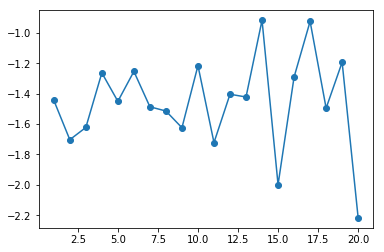

In [253]:
# Check sample measurements
column = "eSn_118_117"
sample = 'NIST + DS 0.5-0.5'

plt.plot(df_DS_inv_sub[df_DS_inv_sub["Filenumber"] == 9210]["cycle"], df_DS_inv_sub[df_DS_inv_sub["Filenumber"] == 9210][column], marker="o")
plt.show()

In [239]:
sample = 'MIL090001 b. 2T+2B DS'
df_int_corr_all[df_int_corr_all["sample"] == sample]["124/117"].mean() - df_int_corr_all[df_int_corr_all["sample"] == 'NIST + DS 0.5-0.5']["124/117"].mean()

nan

In [254]:
df_DS_inv_sub

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,117,123,124,125,126,127,129,119,118,Te/Sn_nat
date,,,,,,,,,,,,,,,,,,,,,
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443655,...,13.102442,-0.014892,1.614665,0.000044,-8.973225e-06,1.067618e-05,0.000041,2.152229,5.812965,-1.988239e-06
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443657,...,12.842116,-0.014591,1.582616,0.000007,-4.492732e-05,-9.101817e-06,-0.000032,2.109397,5.697489,-1.015651e-05
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443696,...,12.607949,-0.014147,1.553528,0.000038,-8.311625e-06,4.377783e-06,-0.000133,2.070814,5.594097,-1.913699e-06
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443601,...,13.127675,-0.014529,1.617468,0.000031,-1.983023e-05,1.587868e-05,-0.000068,2.155804,5.823446,-4.385966e-06
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443661,...,13.430956,-0.014676,1.655101,0.000019,-4.919202e-05,7.224083e-06,0.000037,2.206188,5.958792,-1.063296e-05
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443691,...,13.423944,-0.014614,1.654150,0.000045,-1.770403e-05,2.374283e-06,0.000063,2.204957,5.956089,-3.828499e-06
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443657,...,13.360390,-0.014347,1.646421,0.000027,-2.794502e-05,2.808488e-05,0.000030,2.194477,5.927424,-6.072341e-06
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443676,...,13.258462,-0.014264,1.633863,0.000032,-4.606712e-05,1.295508e-05,-0.000021,2.177765,5.882464,-1.008671e-05
2018-01-11 11:26:00,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,1.38788,-1.111612,0.443680,...,13.216625,-0.014149,1.628779,0.000044,-3.827822e-05,-1.827932e-05,0.000027,2.170947,5.863946,-8.407744e-06


# calculate mean and 2SD for each filenumber

In [255]:
### calculate average and standard deviation of each sample measurement ### 

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_DS_inv_mean = df_DS_inv_sub.drop(["cycle", "Filenumber"], axis=1).groupby(df_DS_inv_sub.index).mean()
df_DS_inv_mean_sd = df_DS_inv_sub.drop(["cycle", "Filenumber"], axis=1).groupby(df_DS_inv_sub.index).agg([np.mean, SE, "count"])
df_DS_inv_mean["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean_sd["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean["Filenumber"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["Filenumber"]
df_DS_inv_mean_sd["Filenumber"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["Filenumber"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_DS_inv_mean_sd[["Filenumber", "sample","eSn_118_117", "Te/Sn_nat"]]
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

Filenumber                     sample eSn_118_117  \
                                                                 mean   
date                                                                    
2018-01-11 11:26:00       9074          NIST + DS 0.5-0.5   -1.485244   
2018-01-11 11:43:00       9076          NIST + DS 0.5-0.5   -1.518566   
2018-01-11 11:59:00       9078          NIST + DS 0.5-0.5   -1.500624   
2018-01-11 12:16:00       9080          NIST + DS 0.5-0.5   -1.401697   
2018-01-11 12:33:00       9082         SPEX1 + DS 0.5-0.5   -0.693156   
2018-01-11 12:50:00       9084          NIST + DS 0.5-0.5   -1.425387   
2018-01-11 13:07:00       9086          NIST + DS 0.4-0.6   -1.502414   
2018-01-11 13:23:00       9088          NIST + DS 0.5-0.5   -1.480281   
2018-01-11 13:40:00       9090                BHVO-2 DS 1   -0.606046   
2018-01-11 13:57:00       9092          NIST + DS 0.5-0.5   -1.463034   
2018-01-11 14:14:00       9094         SPEX1 + DS 0.5-0.5   -0.690963   
2018-01-11 14:31:00       9096          NIST + DS 0.5-0.5   -1.536981   
2018-01-11 14:47:00       9098                    J1 DS 1   -0.752626   
2018-01-11 15:02:00       9100          NIST + DS 0.5-0.5   -1.509545   
2018-01-11 15:19:00       9102                    J1 DS 1   -0.709907   
2018-01-11 15:35:00       9104          NIST + DS 0.5-0.5   -1.495242   
2018-01-11 15:52:00       9106                    J2 DS 1   -0.670465   
2018-01-11 16:09:00       9108          NIST + DS 0.5-0.5   -1.527087   
2018-01-11 16:26:00       9110          NIST + DS 0.4-0.6   -1.485959   
2018-01-11 16:43:00       9112          NIST + DS 0.4-0.6   -1.479745   
2018-01-11 16:59:00       9114          NIST + DS 0.4-0.6   -1.450155   
2018-01-11 17:16:00       9116               ML-2 50 DS 1   -0.638108   
2018-01-11 17:34:00       9118          NIST + DS 0.4-0.6   -1.483771   
2018-01-11 17:51:00       9120                   H11 DS 1   -0.674739   
2018-01-11 18:07:00       9122          NIST + DS 0.4-0.6   -1.477620   
2018-01-11 18:24:00       9124            AII93 I-II DS 1   -0.515204   
2018-01-11 18:41:00       9126          NIST + DS 0.4-0.6   -1.483472   
2018-01-11 18:58:00       9128          NIST + DS 0.4-0.6   -1.426922   
2018-01-11 19:17:00       9130          NIST + DS 0.4-0.6   -1.386068   
2018-01-11 19:34:00       9132          NIST + DS 0.4-0.6   -1.470813   
...                        ...                        ...         ...   
2018-01-12 03:24:00       9188          NIST + DS 0.4-0.6   -1.353164   
2018-01-12 03:41:00       9190          NIST + DS 0.4-0.6   -1.432962   
2018-01-12 03:57:00       9192          NIST + DS 0.4-0.6   -1.357909   
2018-01-12 04:14:00       9194          NIST + DS 0.4-0.6   -1.397639   
2018-01-12 04:31:00       9196          NIST + DS 0.5-0.5   -1.427809   
2018-01-12 04:48:00       9198          NIST + DS 0.4-0.6   -1.376873   
2018-01-12 05:05:00       9200          NIST + DS 0.5-0.5   -1.307501   
2018-01-12 05:21:00       9202          NIST + DS 0.5-0.5   -1.381693   
2018-01-12 05:38:00       9204         SPEX1 + DS 0.5-0.5   -0.600009   
2018-01-12 05:55:00       9206          NIST + DS 0.5-0.5   -1.443655   
2018-01-12 06:12:00       9208  NIST + DS 0.5-0.5 1ppb Te   -1.397912   
2018-01-12 06:29:00       9210          NIST + DS 0.5-0.5   -1.458105   
2018-01-12 06:45:00       9212  NIST + DS 0.5-0.5 2ppb Te   -1.491588   
2018-01-12 07:02:00       9214          NIST + DS 0.5-0.5   -1.377757   
2018-01-12 07:19:00       9216  NIST + DS 0.5-0.5 4ppb Te   -1.716228   
2018-01-12 07:36:00       9218          NIST + DS 0.5-0.5   -1.431761   
2018-01-12 07:53:00       9220  NIST + DS 0.5-0.5 8ppb Te   -1.860032   
2018-01-12 08:09:00       9222          NIST + DS 0.5-0.5   -1.351346   
2018-01-12 08:26:00       9224          NIST + DS 0.5-0.5   -1.435939   
2018-01-12 08:43:00       9226  NIST + DS 0.5-0.5 1ppb Te   -1.508956   
2018-01-12 09:00:00       9228          NIST + DS 0.5-0.5   -1.440488   
2018-

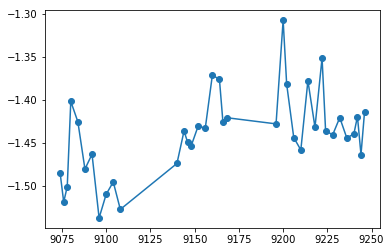

In [256]:
# Check sample measurements
column = 'eSn_118_117'
sample = 'NIST + DS 0.5-0.5'

df_mean_sub = df_DS_inv_mean[df_DS_inv_mean["sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column], marker = "o")
plt.show()

# summarise data per sample 

In [257]:
### calculate average and standard deviation by sample group ###

df_DS_inv_mean_sample_sd = df_DS_inv_mean.drop("Filenumber", axis=1).groupby(df_DS_inv_mean["sample"]).agg([np.mean, SD2])
df_DS_inv_mean_sample_sd["eSn_118_117"]

,mean,SD2
sample,,
AII93 I-II DS 1,-0.481096,0.068218
BHVO-2 DS 1,-0.568566,0.074961
H11 DS 1,-0.621642,0.106194
J1 DS 1,-0.680135,0.148768
J2 DS 1,-0.655812,0.029305
ML-2 50 DS 1,-0.604066,0.068085
NIST + DS 0.4-0.6,-1.433509,0.094112
NIST + DS 0.5-0.5,-1.439737,0.096901
NIST + DS 0.5-0.5 1ppb Te,-1.453434,0.111044


# Calculate Standard-Sample-Bracketing

In [258]:
### calculate Standard-Sample Bracketing ###

# bracketing standard #
std_used = "NIST + DS 0.5-0.5"


# determine at which position the samples are which are bracketed
sub_index = df_DS_inv_mean[(df_DS_inv_mean["sample"].shift(1) == df_DS_inv_mean["sample"].shift(-1)) & (df_DS_inv_mean["sample"].shift(1) == std_used)].index
# remove measurements with values below 0.1V
corr_values = df_DS_inv_mean[df_DS_inv_mean["124"] >= 0.1]
# extract only standard data
corr_values_2 = corr_values[corr_values["sample"] == std_used]

# save sample names
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]

# remove sample names from dataframe for calculation
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

# calculate bracketing 
epsilon_NIST =  ((new - ((new.shift(1) + new.shift(-1))/2)))
epsilon_2 = ((new_2 - ((new_2.shift(1) + new_2.shift(-1))/2)))
# reinsert samples names
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample_2

# select samples by bracketing index
epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
# select only bracketed sample measurements in dataframe
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
epsilon_NIST = epsilon_NIST[(epsilon_NIST["Filenumber"] >= -1) & (epsilon_NIST["Filenumber"] <= 1)]

# select only bracketed standard measurements in dataframe
epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
epsilon_2 = epsilon_2[(epsilon_2["Filenumber"] >= -1) & (epsilon_2["Filenumber"] <= 1)]
# append bracketed sample and standard measurements
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
# sort dataframe by datetime
epsilon_comp = epsilon_comp.sort_index(axis=0)

# Summarise SBB per sample

In [259]:
start = pd.Timestamp('2018-01-11 11:33:00')
end = pd.Timestamp('2018-01-13 00:20:00')
epsilon_comp = epsilon_comp[(epsilon_comp.index > start) & (epsilon_comp.index < end)]

In [260]:
epsilon_comp[["sample","eSn_118_117", "118"]]

,sample,eSn_118_117,118
date,,,
2018-01-11 11:43:00,NIST + DS 0.5-0.5,-0.025632,-0.062545
2018-01-11 11:59:00,NIST + DS 0.5-0.5,-0.040492,0.131123
2018-01-11 12:16:00,NIST + DS 0.5-0.5,0.061308,-0.081628
2018-01-11 12:33:00,SPEX1 + DS 0.5-0.5,0.720386,-0.358176
2018-01-11 12:50:00,NIST + DS 0.5-0.5,0.015602,0.100230
2018-01-11 13:07:00,NIST + DS 0.4-0.6,-0.049581,-1.141877
2018-01-11 13:23:00,NIST + DS 0.5-0.5,-0.036070,-0.150051
2018-01-11 13:40:00,BHVO-2 DS 1,0.865611,0.269225
2018-01-11 13:57:00,NIST + DS 0.5-0.5,0.045597,0.022159


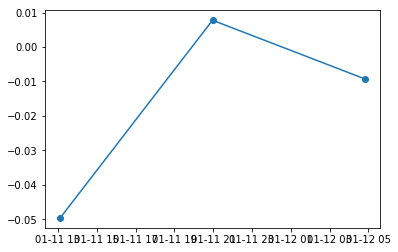

In [261]:
# Check sample measurements
column = 'eSn_118_117'
sample = 'NIST + DS 0.4-0.6'

df_epsilon_sub = epsilon_comp[epsilon_comp["sample"] == sample]
plt.plot(df_epsilon_sub.index, df_epsilon_sub[column], marker = "o")
plt.show()

In [262]:
### average bracketed data by sample category ###
def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

epsilon = epsilon_comp[["eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118", "Q", "fspike","sample"]]
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_sum

eSn_118_117              eSn_122_117               \
                                 mean    SD2 count        mean    SD2 count   
sample                                                                        
BHVO-2 DS 1                     0.883  0.049     2       4.346  0.243     2   
J1 DS 1                         0.796  0.054     3       3.917  0.265     3   
J2 DS 1                         0.787  0.153     2       3.872  0.753     2   
NIST + DS 0.4-0.6              -0.017  0.059     3      -0.084  0.290     3   
NIST + DS 0.5-0.5               0.002  0.082    31       0.008  0.406    31   
NIST + DS 0.5-0.5 1ppb Te      -0.009  0.175     2      -0.044  0.861     2   
NIST + DS 0.5-0.5 2ppb Te      -0.079  0.015     2      -0.388  0.073     2   
NIST + DS 0.5-0.5 4ppb Te      -0.254  0.161     2      -1.252  0.793     2   
NIST + DS 0.5-0.5 8ppb Te      -0.471  0.008     2      -2.319  0.038     2   
SPEX1 + DS 0.5-0.5              0.796  0.104     4       3.917  0.514     4   

                          eSn_124_117              eSn_122_118  ...         \
                                 mean    SD2 count        mean  ...  count   
sample                                                          ...          
BHVO-2 DS 1                     6.035  0.337     2       3.464  ...      2   
J1 DS 1                         5.439  0.369     3       3.122  ...      3   
J2 DS 1                         5.376  1.045     2       3.086  ...      2   
NIST + DS 0.4-0.6              -0.116  0.402     3      -0.067  ...      3   
NIST + DS 0.5-0.5               0.011  0.564    31       0.006  ...     31   
NIST + DS 0.5-0.5 1ppb Te      -0.061  1.195     2      -0.035  ...      2   
NIST + DS 0.5-0.5 2ppb Te      -0.539  0.102     2      -0.310  ...      2   
NIST + DS 0.5-0.5 4ppb Te      -1.739  1.101     2      -0.998  ...      2   
NIST + DS 0.5-0.5 8ppb Te      -3.219  0.052     2      -1.848  ...      2   
SPEX1 + DS 0.5-0.5              5.439  0.714     4       3.122  ...      4   

                          eSn_124_118                   Q              fspike  \
                                 mean    SD2 count   mean    SD2 count   mean   
sample                                                                          
BHVO-2 DS 1                     5.153  0.288     2  0.301  0.000     2 -0.063   
J1 DS 1                         4.644  0.315     3 -0.185  0.001     3  0.049   
J2 DS 1                         4.591  0.893     2 -0.023  0.000     2  0.005   
NIST + DS 0.4-0.6              -0.099  0.344     3 -0.364  0.000     3  0.106   
NIST + DS 0.5-0.5               0.010  0.481    31 -0.000  0.000    31  0.000   
NIST + DS 0.5-0.5 1ppb Te      -0.052  1.021     2 -0.002  0.000     2  0.001   
NIST + DS 0.5-0.5 2ppb Te      -0.461  0.087     2 -0.008  0.000     2  0.002   
NIST + DS 0.5-0.5 4ppb Te      -1.485  0.940     2 -0.006  0.000     2  0.001   
NIST + DS 0.5-0.5 8ppb Te      -2.749  0.045     2 -0.005  0.000     2  0.001   
SPEX1 + DS 0.5-0.5              4.644  0.609     4 -0.061  0.000     4  0.015   

                                      
                           SD2 count  
sample                                
BHVO-2 DS 1                0.0     2  
J1 DS 1                    0.0     3  
J2 DS 1                    0.0     2  
NIST + DS 0.4-0.6          0.0     3  
NIST + DS 0.5-0.5          0.0    31  
NIST + DS 0.5-0.5 1ppb Te  0.0     2  
NIST + DS 0.5-0.5 2ppb Te  0.0     2  
NIST + DS 0.5-0.5 4ppb Te  0.0     2  
NIST + DS 0.5-0.5 8ppb Te  0.0     2  
SPEX1 + DS 0.5-0.5         0.0     4  

[10 rows x 21 columns]

In [29]:
### method to create plots to show bracketing data ###

# sel_ratio = "112/118"
std = "NIST + DS 0.5-0.5"

def plot_epsilon(sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

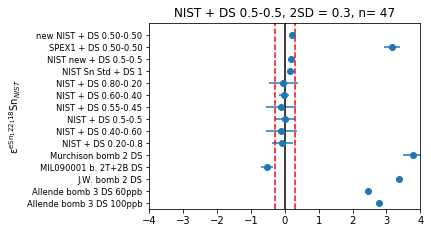

In [31]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_no_bgd_122_118_100ppb_std_rocks_126Te.pdf", bbox_inches='tight')

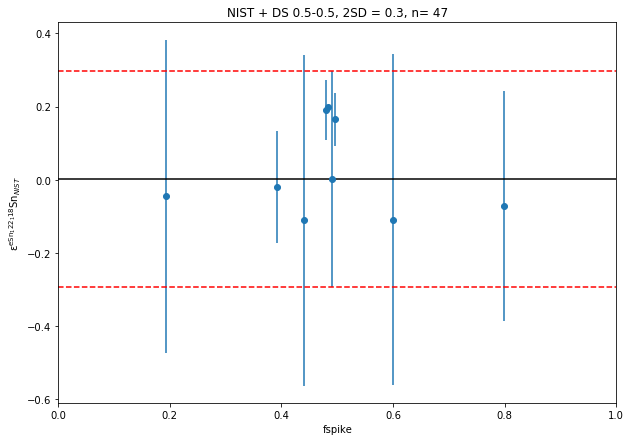

In [35]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_126Te_no_bgd.pdf", bbox_inches='tight')

In [206]:
# save all baseline corrected signal data to cvs
df_all.to_csv(path + "Signals_zero_mix.csv")

In [235]:
# save averaged corrected data to csv
df_DS_inv_mean_sd.to_csv(path + "DS_inv_bgd_corr_exp_126Te_129Xe_corr.csv")

In [236]:
# save all corrected data to csv
df_DS_inv_sub.to_csv(path + "DS_inv_bgd_corr_all_exp_126Te_129Xe_corr.csv")

In [ ]:
### old code used for Testing ###


# For one datapoint
files_1 = 7208

df = NU_data_read(path, sample, cup_config)
cycles = range(1, len(df.data_read(sample).index)+1)

# arbitrary blank positions
#blk1 = [item for item in blk_ls if item < sample]
#blk2 = [item for item in blk_ls if item > sample]
#blk1 = blk1[-1]
#blk2 = blk2[0]
#blk_corr_sample = True
    
if (blk_corr == True) and (blk_corr_sample == True):
    blk_1 = NU_data_read(path, blk1, cup_config)
    blk_2 = NU_data_read(path, blk2, cup_config)
    df_zero = df.data_zero_corr(sample)
    df_bgd_1 = blk_1.data_zero_corr(blk1)
    df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
    df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
    df_bgd_corr = new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    #new_corr.line2_corr(df_bgd_corr, "119")
else:
    df_zero = df.data_zero_corr(sample)
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    #new_corr.line2_corr(df_zero, "119")

data_sample = new_corr.raw_ratios(denom_isotope)
data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
df_zero

In [ ]:
#Spike Calculation uncorrected
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc = data_spike_obj.dspike_corr(3, 6, -0.1, -2, 'x')
beta = data_spike_calc["frac_ins_x2.5"]
beta

In [ ]:
data_spike_calc

In [ ]:
data_corr = {}
data_corr_raw = {}
cycle_no = 20
cycles = range(0, len(data_sample.index))

spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    
    #data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')


In [ ]:
spike_corr

In [ ]:
data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')

In [ ]:
data_corr_raw

In [ ]:
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc_2 = data_spike_obj.dspike_corr(3, 6, -0.1, -2.2, 'x')
data_spike_calc_2["eSn"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)

In [ ]:
data_spike_calc_2

In [ ]:
data_spike_calc_2.to_csv(path+"test_2.csv")

In [ ]:
# epsilon calculation with mean values
#std_mean = corr_values[(corr_values["sample"] == std_used)].mean()
#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample